In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle kernels list

ref                                                            title                                               author           lastRunTime          totalVotes  
-------------------------------------------------------------  --------------------------------------------------  ---------------  -------------------  ----------  
tanujleomessi/noob-90-accuracy                                 Noob (90% accuracy)                                 tanujleomessi    2021-08-02 07:31:34           5  
yus002/tps-lgbm-model                                          TPS LGBM model                                      Yue Sun          2021-08-02 06:55:23          17  
alaasedeeq/object-oriented-programming-for-data-science        Object oriented programming for Data Science        Alaa Sedeeq      2021-08-02 04:19:55          33  
bserdogan/predicting-house-prices-xgboost-gbm-models           Predicting House Prices XGBoost + GBM Models        bse              2021-08-02 05:34:17          24  
kaan

In [ ]:
!kaggle datasets download -w --unzip grassknoted/asl-alphabet 

100% 1.02G/1.03G [00:10<00:00, 86.8MB/s]
100% 1.03G/1.03G [00:10<00:00, 108MB/s] 


In [ ]:
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from time import perf_counter

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

def printmd(string):
  display(Markdown(string))

In [ ]:

dir = Path('/content/input/asl_alphabet_train')
file_paths = list(dir.glob(r'**/*.jpg'))
print(file_paths[1:6])

[PosixPath('/content/input/asl_alphabet_train/nothing/nothing1836.jpg'), PosixPath('/content/input/asl_alphabet_train/nothing/nothing2879.jpg'), PosixPath('/content/input/asl_alphabet_train/nothing/nothing2392.jpg'), PosixPath('/content/input/asl_alphabet_train/nothing/nothing2857.jpg'), PosixPath('/content/input/asl_alphabet_train/nothing/nothing1492.jpg')]


In [ ]:
dir

PosixPath('/content/input/asl_alphabet_train')

In [ ]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['F' 'M' 'D' 'S' 'I' 'R' 'H' 'X' 'J' 'A' 'del' 'Y' 'N' 'K' 'B' 'L' 'Z' 'Q'
 'space' 'T' 'nothing' 'O' 'V' 'C' 'W' 'E' 'G' 'P' 'U']


,Filepath,Label
0,/content/input/asl_alphabet_train/F/F2299.jpg,F
1,/content/input/asl_alphabet_train/M/M1777.jpg,M
2,/content/input/asl_alphabet_train/D/D1281.jpg,D
3,/content/input/asl_alphabet_train/S/S771.jpg,S
4,/content/input/asl_alphabet_train/I/I2020.jpg,I


In [ ]:
val_count = df['Label'].value_counts()
val_count

D          3000
L          3000
K          3000
del        3000
J          3000
nothing    3000
N          3000
S          3000
E          3000
R          3000
F          3000
Z          3000
T          3000
B          3000
G          3000
Y          3000
M          3000
I          3000
space      3000
W          3000
H          3000
O          3000
P          3000
Q          3000
U          3000
A          3000
V          3000
C          3000
X          3000
Name: Label, dtype: int64

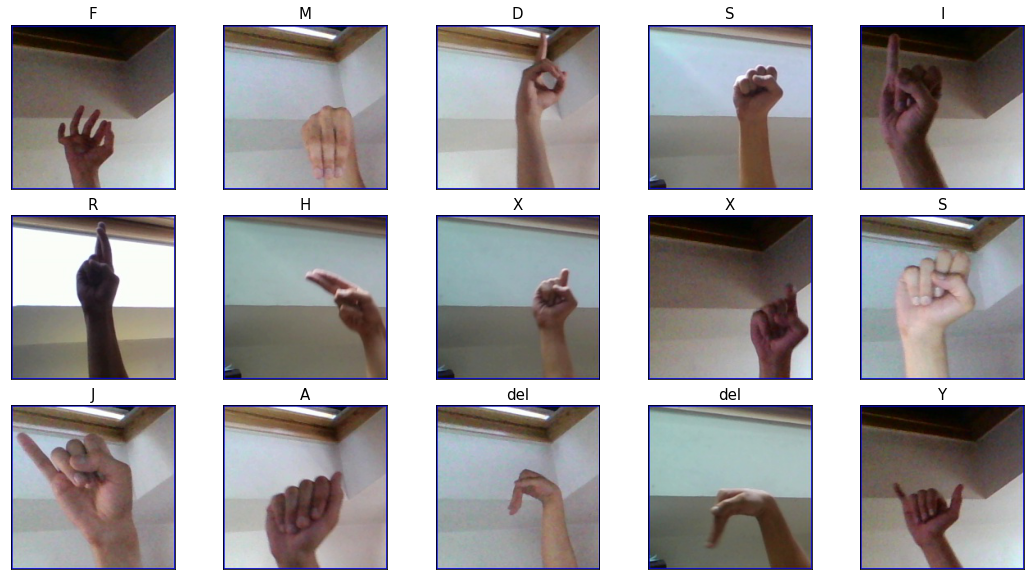

In [ ]:
#Displaying some pictures
fig, axes = plt.subplots(nrows = 3,ncols =5, figsize =(15,8),
                         subplot_kw = {'xticks' : [], 'yticks':[]})
#fig.set_title("dfg")
for idx, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.Filepath[idx]))
  ax.set_title(df.Label[idx], fontsize = 15)
plt.tight_layout(pad = 0.5)
plt.show()

In [ ]:
printmd("Train Test dataset")

In [ ]:
#preparing datasets for training and testing
train_df, test_df = train_test_split(df.sample(frac = 0.05),test_size = 0.1, random_state = 0)

# **Loading Images with generator and Data Augmentation**

In [ ]:
def preprocess():
  #Loading data with generator
  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
      validation_split = 0.1
  )

  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,

  )

  train_images = train_generator.flow_from_dataframe(
      dataframe = train_df,
      x_col='Filepath',
      y_col='Label',
      shuffle= True,
      target_size=(224,224),
      color_map = 'rgb',
      batch_size = 32,
      class_mode='categorical',
      seed = 0,
      subset = 'training',
      # rotation_range = 30,
      # zoom_range = 0.15,
      # height_shift_range = 0.2,
      # width_shift_range = 0.2,
      # shear_range = 0.15,
      # fill_mode = "nearest",
      # horizontal_flip = True
  )

  val_images = train_generator.flow_from_dataframe(
      dataframe= train_df,
      x_col = 'Filepath',
      y_col = 'Label',
      target_size = (224,224),
      color_mode = 'rgb',
      class_mode = 'categorical',
      batch_size = 32,
      seed = 0,
      shuffle = True,
      subset = 'validation',
      # rotation_range = '30',
      # zoom_range = 0.15,
      # shear_range = 0.15,
      # height_shift_range = 0.2,
      # width_shift_range = 0.2,
      # horizontal_flip = True, 
      # fill_mode= 'nearest'

  )

  test_images = test_generator.flow_from_dataframe(
      dataframe= test_df,
      x_col = 'Filepath',
      y_col = 'Label',
      target_size = (224,224),
      color_mode = 'rgb',
      class_mode = 'categorical',
      batch_size = 32,
      shuffle = False

  )
  return train_generator, test_generator, train_images, val_images, test_images

In [ ]:
#Dictionary of models
models = {
    'MobileNet' : { 'model': tf.keras.applications.MobileNet, "perf":0 },
    'MobileNetV2' : { 'model': tf.keras.applications.MobileNet, 'perf':0 },
    'MobileNetV3Large' : { 'model': tf.keras.applications.MobileNetV3Large, 'perf':0 },
    'MobileNetV3Small' : { 'model': tf.keras.applications.MobileNetV3Small, 'perf':0 },

    'DenseNet121' : { 'model' : tf.keras.applications.DenseNet121, 'perf': 0},
    'DenseNet169' : { 'model' : tf.keras.applications.DenseNet169, 'perf': 0},
    'DenseNet201' : { 'model' : tf.keras.applications.DenseNet201, 'perf':0},

    'EfficientNetB1': { 'model': tf.keras.applications.EfficientNetB1, 'perf':0},
    'EfficientNetB2': { 'model': tf.keras.applications.EfficientNetB2, 'perf':0},
    'EfficientNetB3': { 'model': tf.keras.applications.EfficientNetB3, 'perf':0},
    'EfficientNetB4': { 'model': tf.keras.applications.EfficientNetB4, 'perf':0},

    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},


}

In [ ]:
#Loading and preparing pretrained-model 
def get_model(model):
  # print('*')
  pretrained_model = model(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )

  pretrained_model.trainable = False

  x1 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
  x2 = tf.keras.layers.Dense(128, activation='relu')(x1)
  #x3 = tf.keras.layers.Dense(64, activation='relu')(x2)
  # print('*')
  outputs = tf.keras.layers.Dense(29, activation= 'softmax')(x2)

  model = tf.keras.Model(inputs = pretrained_model.input, outputs = outputs)
  # print('*')
  model.compile(
      optimizer = 'adam',
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )
  return model


In [ ]:
#Create Generators 

train_generator, test_generator, train_images, val_images, test_images = preprocess()

In [ ]:
#Training Different models
for name, model in models.items():
  mdl = get_model(model['model'])
  models[name]['model'] = mdl
  st = perf_counter()

  #Model Fitting
  hist = mdl.fit( train_images, validation_data = val_images, epochs = 1, verbose = 0)

  duration = round(perf_counter()-st, 3)
  models[name]['perf'] = duration

  acc = hist.history['val_accuracy']
  models[name]['val_acc'] = [round(a,3) for a in acc]

  print(f"{name} -> Time Taken : {duration} sec")
